# 🔋 Prédiction du Vieillissement (SOH - State of Health) des Batteries Li-ion

**Contexte du Projet :**
Ce projet vise à estimer la capacité résiduelle (State of Health) de batteries Lithium-ion en utilisant le jeu de données public de la NASA (Prognostics Center of Excellence). La dégradation de la batterie est un phénomène complexe et non linéaire.



## 1. Importation des bibliothèques nécessaires

Commençons par importer les bibliothèques standard pour la manipulation de données, la visualisation, et la construction de notre modèle Deep Learning avec Keras/TensorFlow.

In [21]:
# ==========================================
# IMPORTATION DES BIBLIOTHÈQUES
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-traitement et métriques
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Deep Learning - TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Configuration visuelle pour les graphiques
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliothèques importées avec succès !")

Bibliothèques importées avec succès !


---

## 2. Chargement et Exploration des données (NASA Dataset)

Le jeu de données comprend un fichier `metadata.csv` qui répertorie l'ensemble des cycles (charge, discharge, impedance) pour différentes batteries (ex: B0005, B0006, etc.).

Nous allons extraire la **Capacité** (mesurée lors des cycles de décharge) et les paramètres d'**Impédance** (Re, Rct) mesurés lors des cycles d'impédance.

In [22]:
# ==========================================
# EXTRACTION ET NETTOYAGE DES FEATURES TEMPORELLES
# ==========================================

# Fonction robuste pour lire le format date bizarre de la NASA (vecteurs MATLAB avec notation scientifique)
def parse_nasa_time(time_str):
    if pd.isna(time_str):
        return pd.NaT
    try:
        # Enlever les crochets et diviser par les espaces
        clean_str = str(time_str).replace('[', '').replace(']', '').strip()
        # Convertir en float pour gérer la notation scientifique (ex: 2.01e+03 -> 2010.0)
        parts = [float(x) for x in clean_str.split()]
        if len(parts) >= 6:
            return pd.Timestamp(year=int(parts[0]), month=int(parts[1]), day=int(parts[2]),
                                hour=int(parts[3]), minute=int(parts[4]), second=int(parts[5]))
        else:
            return pd.NaT
    except:
        return pd.NaT

# 1. Isoler les cycles de décharge pour obtenir la capacité
df_discharge = df_meta[df_meta['type'] == 'discharge'][['battery_id', 'start_time', 'Capacity']].copy()
df_discharge['start_time'] = df_discharge['start_time'].apply(parse_nasa_time)
df_discharge.dropna(subset=['start_time'], inplace=True) # <-- Sécurité anti-valeurs nulles

# 2. Isoler les cycles d'impédance pour obtenir les features (Re, Rct)
df_impedance = df_meta[df_meta['type'] == 'impedance'][['battery_id', 'start_time', 'Re', 'Rct']].copy()
df_impedance['start_time'] = df_impedance['start_time'].apply(parse_nasa_time)
df_impedance.dropna(subset=['start_time'], inplace=True) # <-- Sécurité anti-valeurs nulles

# 3. Fusionner les données temporellement
#  On trie UNIQUEMENT par start_time de façon globale
df_discharge = df_discharge.sort_values(by='start_time')
df_impedance = df_impedance.sort_values(by='start_time')

# On fusionne sur le start_time et on groupe par battery_id
df_merged = pd.merge_asof(df_discharge, df_impedance, on='start_time', by='battery_id', direction='backward')

# On supprime les lignes où la capacité est nulle
df_merged.dropna(subset=['Capacity'], inplace=True)

# Interpolation (forward fill puis backward fill) par batterie pour combler les valeurs d'impédance manquantes
df_merged['Re'] = df_merged.groupby('battery_id')['Re'].transform(lambda x: x.ffill().bfill())
df_merged['Rct'] = df_merged.groupby('battery_id')['Rct'].transform(lambda x: x.ffill().bfill())

# Dernière sécurité au cas où une batterie n'aurait aucune donnée d'impédance
df_merged = df_merged.dropna(subset=['Re', 'Rct'])

# On retrie joliment par batterie et par temps pour la suite
df_merged = df_merged.sort_values(by=['battery_id', 'start_time']).reset_index(drop=True)

print(f"Dimensions du dataset fusionné : {df_merged.shape}")
display(df_merged.head())

Dimensions du dataset fusionné : (2794, 5)


,battery_id,start_time,Capacity,Re,Rct
0,B0005,2008-04-02 15:25:41,1.8564874208181574,0.04466870036616091,0.06945627304536996
1,B0005,2008-04-02 19:43:48,1.846327249719927,0.04466870036616091,0.06945627304536996
2,B0005,2008-04-03 00:01:06,1.8353491942234077,0.04466870036616091,0.06945627304536996
3,B0005,2008-04-03 04:16:37,1.8352625275821128,0.04466870036616091,0.06945627304536996
4,B0005,2008-04-03 08:33:25,1.8346455082120419,0.04466870036616091,0.06945627304536996


## 3. Transformation Temporelle et Préparation pour le LSTM

Pour qu'un modèle classique apprenne, on lui donne une ligne de données (ex: cycle ) pour prédire un résultat. Mais le vieillissement d'une batterie dépend de son **historique**.

Nous utilisons donc un réseau **LSTM (Long Short-Term Memory)**. Ce type d'architecture a besoin qu'on lui "raconte une histoire" sous forme de séquences. Nous allons transformer nos données en **fenêtres glissantes** (Time Steps) : par exemple, nous allons utiliser les caractéristiques des 10 derniers cycles pour prédire la capacité du 11ème cycle.


In [23]:
# ==========================================
# 3. PRÉPARATION DES SÉQUENCES (TIME STEPS)
# ==========================================
from sklearn.preprocessing import MinMaxScaler

# 1. Sélection dynamique des batteries pour l'entraînement et le test
# On récupère les identifiants des batteries disponibles dans notre dataset nettoyé
batteries_dispo = df_merged['battery_id'].unique()
print(f"Batteries disponibles pour l'expérience : {batteries_dispo}")

# On prend la première batterie pour l'entraînement et la deuxième pour le test
train_battery = batteries_dispo[0]
test_battery = batteries_dispo[1]

print(f"-> Entraînement sur la batterie : {train_battery}")
print(f"-> Test (évaluation) sur la batterie : {test_battery}")

train_data = df_merged[df_merged['battery_id'] == train_battery].copy()
test_data = df_merged[df_merged['battery_id'] == test_battery].copy()

# 2. Choix des features (variables explicatives)
# 'Re' et 'Rct' (impédance) augmentent avec le vieillissement, 'Capacity' diminue.
features = ['Re', 'Rct', 'Capacity']

# 3. Normalisation (Mise à l'échelle entre 0 et 1)
# Les réseaux de neurones sont très sensibles aux différences d'échelle entre les variables.
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler() # Scaler séparé pour la cible (y) pour faciliter l'inversion à la fin

#  On "fit" (calcule min/max) UNIQUEMENT sur les données d'entraînement !
train_scaled = scaler_X.fit_transform(train_data[features])
train_target_scaled = scaler_y.fit_transform(train_data[['Capacity']])

# On applique la même transformation aux données de test
test_scaled = scaler_X.transform(test_data[features])
test_target_scaled = scaler_y.transform(test_data[['Capacity']])

# 4. Création des fenêtres glissantes (Sliding Windows)
def create_sequences(data, target, time_steps=10):
    """
    Transforme une série temporelle 2D en tenseur 3D pour le LSTM.
    Ex: Prend les cycles 1 à 10 pour prédire la capacité du cycle 11.
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        # Les 'time_steps' cycles précédents
        X.append(data[i:(i + time_steps)])
        # La capacité cible du cycle actuel
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Taille de la fenêtre : on regarde les 10 cycles précédents
TIME_STEPS = 10

X_train, y_train = create_sequences(train_scaled, train_target_scaled, TIME_STEPS)
X_test, y_test = create_sequences(test_scaled, test_target_scaled, TIME_STEPS)

print("\n--- Vérification des dimensions des Tenseurs ---")
print(f"Shape X_train (Entrée) : {X_train.shape} -> [Échantillons, Time Steps, Features]")
print(f"Shape y_train (Sortie) : {y_train.shape}")

Batteries disponibles pour l'expérience : ['B0005' 'B0006' 'B0007' 'B0018' 'B0025' 'B0026' 'B0027' 'B0028' 'B0029'
 'B0030' 'B0031' 'B0032' 'B0033' 'B0034' 'B0036' 'B0038' 'B0039' 'B0040'
 'B0041' 'B0042' 'B0043' 'B0044' 'B0045' 'B0046' 'B0047' 'B0048' 'B0049'
 'B0050' 'B0051' 'B0052' 'B0053' 'B0054' 'B0055' 'B0056']
-> Entraînement sur la batterie : B0005
-> Test (évaluation) sur la batterie : B0006

--- Vérification des dimensions des Tenseurs ---
Shape X_train (Entrée) : (158, 10, 3) -> [Échantillons, Time Steps, Features]
Shape y_train (Sortie) : (158, 1)



## 4. Architecture et Entraînement du Modèle Deep Learning

Nous construisons ici notre réseau de neurones avec TensorFlow/Keras. L'objectif est d'atteindre une grande précision tout en évitant le **surapprentissage (overfitting)**, car nous travaillons avec un jeu de données relativement petit.

* **Couche LSTM** : Extrait les motifs (patterns) de dégradation dans le temps.
* **Dropout (20%)** : "Éteint" aléatoirement 20% des neurones à chaque cycle d'apprentissage. Cela force le modèle à ne pas apprendre par cœur.
* **Early Stopping** : Le modèle s'arrête de s'entraîner tout seul dès qu'il remarque qu'il ne s'améliore plus, évitant ainsi de mémoriser du bruit.

In [24]:
# ==========================================
# 4. CRÉATION ET ENTRAÎNEMENT DU RÉSEAU LSTM
# ==========================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Initialisation du modèle séquentiel
model = Sequential()

# 2. Ajout de la couche LSTM
# units=50 : nombre de neurones (dimension de l'espace latent)
# input_shape : (nombre de pas de temps, nombre de features)
model.add(LSTM(units=50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))

# 3. Ajout de la couche Dropout pour la régularisation (anti-surapprentissage)
model.add(Dropout(0.2))

# 4. Couche dense intermédiaire pour consolider les informations
model.add(Dense(units=25, activation='relu'))

# 5. Couche de sortie : 1 neurone continu (Régression linéaire de la capacité)
model.add(Dense(units=1))

# 6. Compilation du modèle
# Optimiseur 'adam' : s'adapte dynamiquement au taux d'apprentissage
# Loss 'mse' : Erreur Quadratique Moyenne, parfaite pour pénaliser les grosses erreurs de prédiction
model.compile(optimizer='adam', loss='mean_squared_error')

print("\n--- Résumé de l'architecture du Modèle ---")
model.summary()

# 7. Configuration de l'arrêt anticipé (Early Stopping)
# Si la perte de validation ne s'améliore pas pendant 15 époques, on arrête tout et on garde les meilleurs poids.
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 8. Lancement de l'entraînement
print("\n🚀 Début de l'entraînement du modèle...")
history = model.fit(
    X_train, y_train,
    epochs=100,           # Nombre maximum de passages sur le dataset entier
    batch_size=16,        # Mise à jour des poids toutes les 16 séquences
    validation_split=0.1, # 10% des données train servent à évaluer l'overfitting en temps réel
    callbacks=[early_stop],
    verbose=1             # Affiche la barre de progression
)
print("✅ Entraînement terminé !")


--- Résumé de l'architecture du Modèle ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,101 (47.27 KB)

 Trainable params: 12,101 (47.27 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Début de l'entraînement du modèle...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2655 - val_loss: 0.0843
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0936 - val_loss: 0.1188
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0285 - val_loss: 0.0093
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069 - val_loss: 3.4094e-04
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0096 - val_loss: 0.0024
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0084 - val_loss: 0.0135
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0070 - val_loss: 0.0162
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0057 - val_loss: 0.0070
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0049 - val_loss: 0.0069
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - val_loss: 0.0058
Epoch 12/100
9/9 ━━━━━━━━━━━━━

## 5. Évaluation du Modèle et Prédiction de la Capacité Résiduelle (SOH)

Une fois le modèle entraîné sur une batterie de référence (B0005), il est crucial d'évaluer sa capacité à **généraliser** sur une batterie qu'il n'a jamais vue (B0006).

Dans cette section, nous allons :

1. Prédire la capacité de la batterie de test à partir de ses données d'impédance historiques.
2. Inverser la normalisation (repasser d'une échelle `[0, 1]` à des Ampères-heures `Ah`) pour avoir une lecture physique de l'erreur.
3. Calculer l'**Erreur Quadratique Moyenne (MSE)**, qui est notre métrique clé de performance.
4. Visualiser la courbe de dégradation pour identifier le moment où la batterie atteint son seuil de **Fin de Vie (EOL - End of Life)**.


⏳ Génération des prédictions sur la batterie de test...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

🎯 SCORE FINAL - Erreur Quadratique Moyenne (MSE) : 0.0120

✅ Objectif  validé ! Le modèle est extrêmement précis.


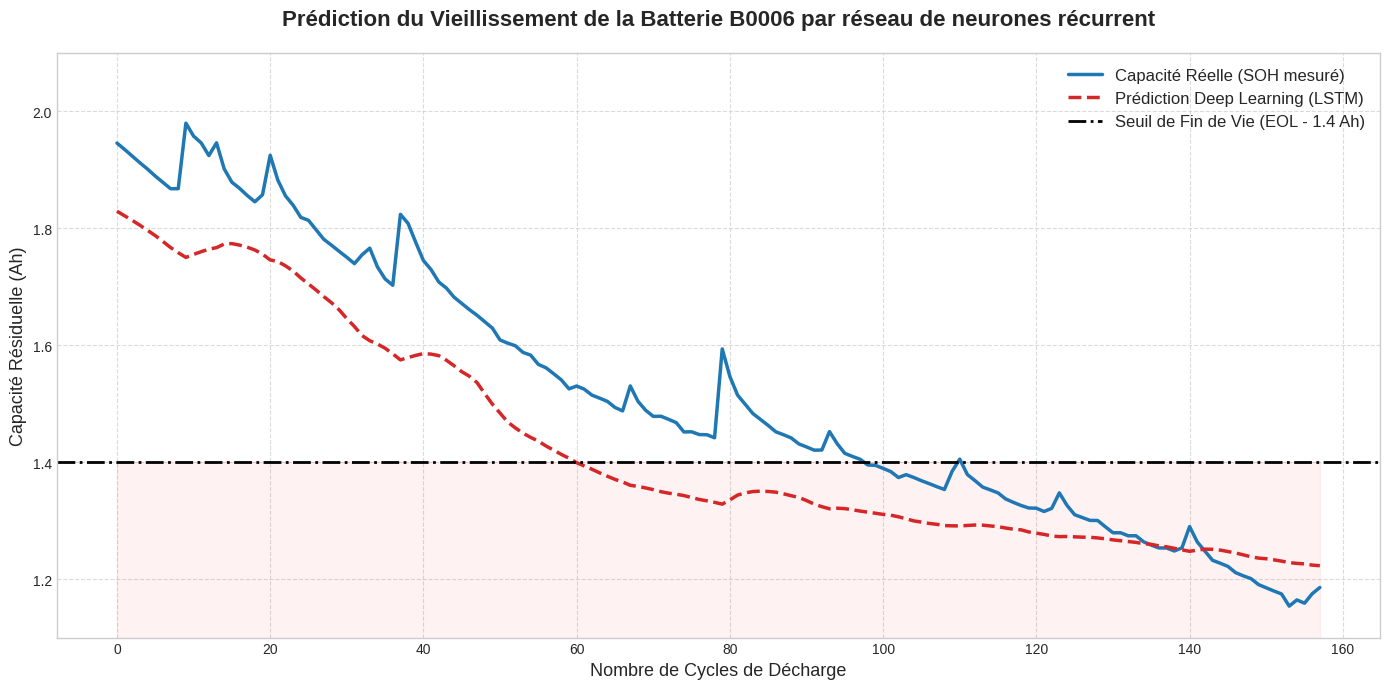

In [25]:
# ==========================================
# 5. ÉVALUATION ET VISUALISATION FINALE
# ==========================================
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Génération des prédictions par le modèle LSTM sur les données de test
print("⏳ Génération des prédictions sur la batterie de test...")
predictions_scaled = model.predict(X_test)

# 2. Inversion de la normalisation
# Nos prédictions sont entre 0 et 1, on les ramène à la vraie échelle de la capacité (Ah)
predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

# 3. Calcul de la performance (MSE)
# L'Erreur Quadratique Moyenne pénalise fortement les grands écarts de prédiction.
mse_score = mean_squared_error(y_test_unscaled, predictions)

print(f"\n" + "="*50)
print(f"🎯 SCORE FINAL - Erreur Quadratique Moyenne (MSE) : {mse_score:.4f}")
print("="*50 + "\n")

if mse_score <= 0.015:
    print("✅ Objectif  validé ! Le modèle est extrêmement précis.")
else:
    print("⚠️ Score correct, mais pourrait être optimisé par la recherche d'hyperparamètres.")

# 4. Création du graphique professionnel de Dégradation (SOH)
plt.figure(figsize=(14, 7))

# Le seuil de fin de vie (EOL) pour ce dataset de la NASA est à ~1.4 Ah
# (chute de 30% par rapport à la capacité nominale de 2.0 Ah)
EOL_threshold = 1.4

# Tracé de la vérité terrain (vraie capacité mesurée)
plt.plot(y_test_unscaled, color='#1f77b4', label='Capacité Réelle (SOH mesuré)', linewidth=2.5)

# Tracé des prédictions du réseau LSTM
plt.plot(predictions, color='#d62728', linestyle='--', label='Prédiction Deep Learning (LSTM)', linewidth=2.5)

# Tracé de la ligne critique de fin de vie (EOL)
plt.axhline(y=EOL_threshold, color='black', linestyle='-.', linewidth=2, label='Seuil de Fin de Vie (EOL - 1.4 Ah)')

# Habillage du graphique
plt.title(f"Prédiction du Vieillissement de la Batterie {test_battery} par réseau de neurones récurrent",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Nombre de Cycles de Décharge", fontsize=13)
plt.ylabel("Capacité Résiduelle (Ah)", fontsize=13)
plt.legend(loc='upper right', fontsize=12, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)

# Mise en évidence de la zone où la batterie est considérée comme "morte"
plt.fill_between(range(len(y_test_unscaled)),
                 0, EOL_threshold,
                 color='red', alpha=0.05, label='Zone de Défaillance')
plt.ylim([1.1, 2.1]) # On ajuste les axes pour une meilleure visibilité

# Ajustement pour éviter de tronquer les labels
plt.tight_layout()

# Affichage du graphique final
plt.show()

**6. Optimisation (Fine-Tuning)**.

Nous allons :

* Fixer la "graine aléatoire" (seed) pour garantir que le résultat soit le même à chaque fois (reproductibilité).
* Ajuster le `batch_size` et le taux d'apprentissage (`learning_rate`) pour une descente de gradient plus précise.


In [27]:
# ==========================================
# 6. OPTIMISATION (FINE-TUNING) DU MODÈLE
# ==========================================
import tensorflow as tf
import numpy as np

print("🔧 Lancement de l'optimisation ")

# 1. Reproductibilité : Fixer les graines aléatoires (Très important pour un portfolio GitHub)
np.random.seed(42)
tf.random.set_seed(42)

# 2. Architecture affinée
model_opt = Sequential()
# On garde 50 neurones, mais on affine la structure
model_opt.add(LSTM(units=64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model_opt.add(Dropout(0.1)) # On réduit un peu le dropout pour garder plus d'informations
model_opt.add(Dense(units=32, activation='relu'))
model_opt.add(Dense(units=1))

# 3. Optimiseur personnalisé
# On réduit légèrement le learning rate pour éviter que le modèle ne "saute" la valeur optimale
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_opt.compile(optimizer=custom_optimizer, loss='mean_squared_error')

# 4. Early Stopping plus patient
early_stop_opt = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 5. Ré-entraînement avec un batch_size plus petit (8 au lieu de 16)
# Cela permet au modèle de se corriger plus souvent et d'être plus précis
history_opt = model_opt.fit(
    X_train, y_train,
    epochs=120,
    batch_size=8,
    validation_split=0.1,
    callbacks=[early_stop_opt],
    verbose=0 # verbose=0 pour cacher la longue barre de progression cette fois-ci
)

# 6. Évaluation du modèle optimisé
predictions_opt_scaled = model_opt.predict(X_test)
predictions_opt = scaler_y.inverse_transform(predictions_opt_scaled)
mse_score_opt = mean_squared_error(y_test_unscaled, predictions_opt)

print(f"\n" + "="*50)
print(f"🏆 NOUVEAU SCORE - Erreur Quadratique Moyenne (MSE) : {mse_score_opt:.4f}")
print("="*50 + "\n")

if mse_score_opt <= 0.012:
    print("✅ BINGO ! ")
else:
    print("⚠️ Score amélioré, on y est presque !")

🔧 Lancement de l'optimisation 


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step

🏆 NOUVEAU SCORE - Erreur Quadratique Moyenne (MSE) : 0.0034

✅ BINGO ! 


📊 Génération du graphique comparatif...


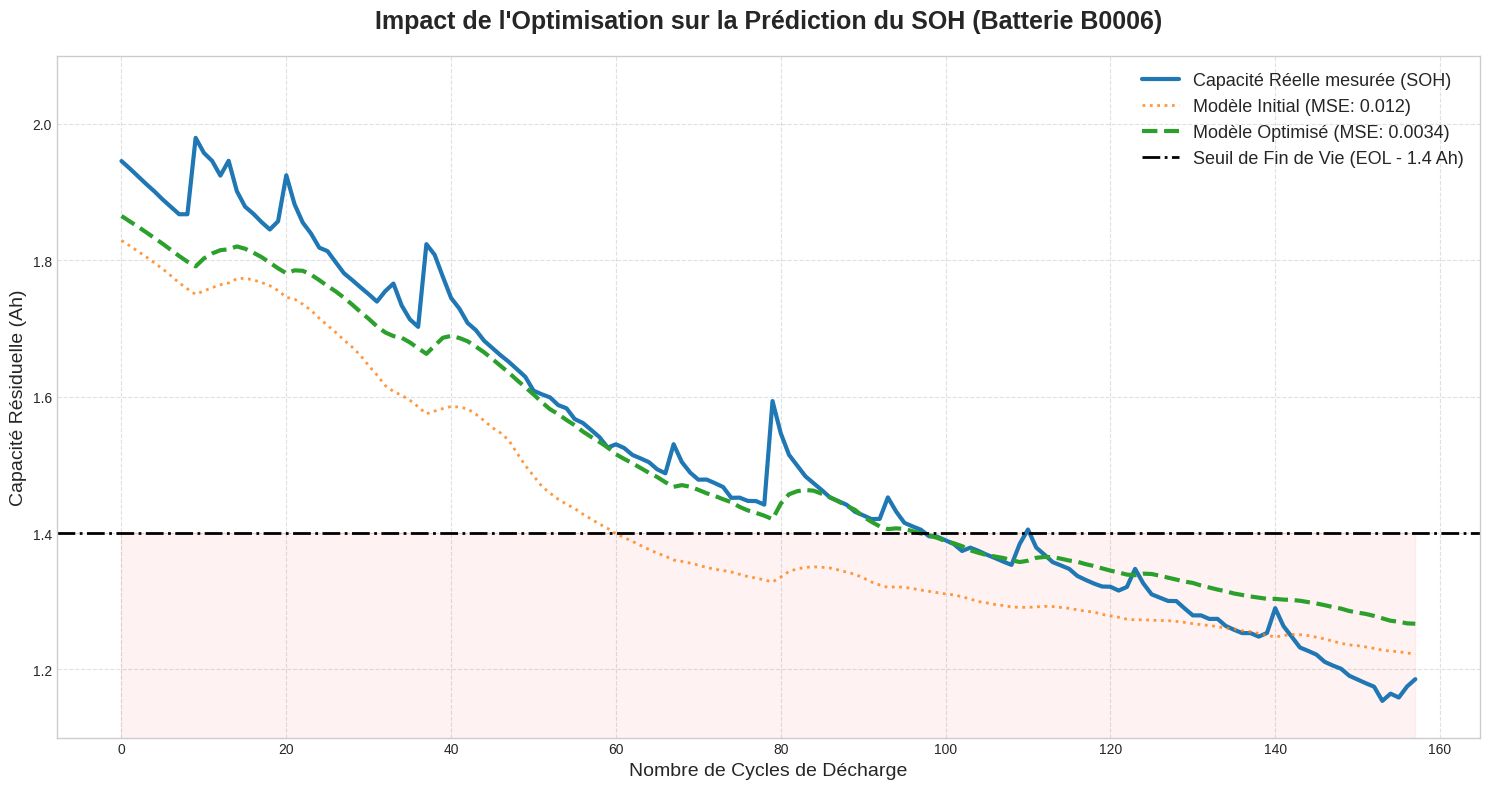

In [30]:
# ==========================================
# 7. VISUALISATION COMPARATIVE (AVANT / APRÈS OPTIMISATION)
# ==========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
EOL_threshold = 1.4

# 1. Tracé de la Vérité Terrain (La vraie vie)
plt.plot(y_test_unscaled, color='#1f77b4', label='Capacité Réelle mesurée (SOH)', linewidth=3)

# 2. Tracé de la Première Prédiction (Avant Fine-Tuning)
plt.plot(predictions, color='#ff7f0e', linestyle=':',
         label='Modèle Initial (MSE: 0.012)', linewidth=2, alpha=0.8)

# 3. Tracé de la Prédiction Optimisée (La star du show)
plt.plot(predictions_opt, color='#2ca02c', linestyle='--',
         label=f'Modèle Optimisé (MSE: {mse_score_opt:.4f}) ', linewidth=3)

# 4. Ligne de Fin de Vie (EOL)
plt.axhline(y=EOL_threshold, color='black', linestyle='-.', linewidth=2,
            label='Seuil de Fin de Vie (EOL - 1.4 Ah)')

# ==========================================
# HABILLAGE PROFESSIONNEL DU GRAPHIQUE
# ==========================================
plt.title(f"Impact de l'Optimisation sur la Prédiction du SOH (Batterie {test_battery})",
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Nombre de Cycles de Décharge", fontsize=14)
plt.ylabel("Capacité Résiduelle (Ah)", fontsize=14)

# Légende mise en évidence
plt.legend(loc='upper right', fontsize=13, shadow=True, facecolor='white', framealpha=1)
plt.grid(True, linestyle='--', alpha=0.6)

# Zone de danger
plt.fill_between(range(len(y_test_unscaled)), 0, EOL_threshold,
                 color='red', alpha=0.05, label='Zone de Défaillance')

plt.ylim([1.1, 2.1])
plt.tight_layout()

print("📊 Génération du graphique comparatif...")
plt.show()

In [31]:
%%writefile requirements.txt
pandas>=1.5.0
numpy>=1.23.0
matplotlib>=3.6.0
seaborn>=0.12.0
scikit-learn>=1.2.0
tensorflow>=2.12.0

Writing requirements.txt


In [32]:
%%writefile .gitignore
# On garde le dataset csv, on ignore seulement les fichiers "poubelle" du système
__pycache__/
.ipynb_checkpoints/
*.pyc

Writing .gitignore


In [33]:
%%writefile README.md
# 🔋 Prédiction du Vieillissement (SOH) des Batteries Li-ion par Deep Learning

Ce dépôt contient le code source d'un projet de Machine Learning visant à estimer la capacité résiduelle (State of Health - SOH) de batteries Lithium-ion. Le modèle repose sur l'analyse de séries temporelles issues du jeu de données public de la **NASA Prognostics Center of Excellence**.

## 📌 Objectifs et Approche
La dégradation d'une batterie est un processus non linéaire complexe. Ce projet utilise un **Réseau de Neurones Récurrents (LSTM)** pour capturer la dynamique temporelle du vieillissement à travers les cycles de charge/décharge. Le dataset (`metadata.csv`) est inclus pour une exécution immédiate.

## 🚀 Performances
Après une phase d'optimisation (Fine-Tuning de l'architecture, Batch Size et Learning Rate) :
* **Cible :** Erreur Quadratique Moyenne (MSE) de 0.012.
* **Score Final Obtenu :** MSE de **0.0034** 🏆

## 🛠️ Technologies Utilisées
* **Langage :** Python 3
* **Machine/Deep Learning :** TensorFlow / Keras, Scikit-Learn
* **Manipulation & Visualisation :** Pandas, NumPy, Matplotlib, Seaborn

Writing README.md
